Importing the Libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer#use to give weights based on importance of the word
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [16]:
data=pd.read_csv("/content/Reviews.csv")
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396554 entries, 0 to 396553
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      396554 non-null  int64 
 1   ProductId               396554 non-null  object
 2   UserId                  396554 non-null  object
 3   ProfileName             396536 non-null  object
 4   HelpfulnessNumerator    396554 non-null  int64 
 5   HelpfulnessDenominator  396554 non-null  int64 
 6   Score                   396554 non-null  int64 
 7   Time                    396554 non-null  int64 
 8   Summary                 396531 non-null  object
 9   Text                    396553 non-null  object
dtypes: int64(5), object(5)
memory usage: 30.3+ MB


In [18]:
requiredData=data[['Text','Score']].copy()

In [19]:
requiredData.info()
requiredData.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396554 entries, 0 to 396553
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    396553 non-null  object
 1   Score   396554 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4


In [20]:
requiredData['Score'].value_counts()

,count
Score,
5,252588
4,56424
1,36756
3,29818
2,20968


Converting score column into binary sentiment (positive review or negative review)

In [21]:
#removing neutral review (ie-'score'=3)
requiredData=requiredData[requiredData['Score']!=3]

In [22]:
requiredData['Sentiment']=requiredData['Score'].apply(lambda score:1 if score>3 else 0)

In [23]:
requiredData=requiredData.drop('Score',axis=1)
requiredData

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
...,...,...
396549,I picked this up to try oil pulling. It works...,1
396550,"No flavor, priced too high for this reason.the...",0
396551,This sunflower oil is the high quality you nee...,1
396552,I received this product very quickly and the o...,1


In [24]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#cleaning and channelizing the review text
def preprocess_text(text):
    text = str(text)
    #removing html tags if any and letters which are not character and space
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

    tokens = word_tokenize(text) #converting the sentence into list of words

    #removing stopwords like 'it','the','this' etc and converting the actual word into dictionary form(using lemmatizer)
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(processed_tokens)

requiredData['Processed_Text'] = requiredData['Text'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
requiredData

,Text,Sentiment,Processed_Text
0,I have bought several of the Vitality canned d...,1,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,0,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,1,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,0,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,1,great taffy great price wide assortment yummy ...
...,...,...,...
396549,I picked this up to try oil pulling. It works...,1,picked try oil pulling work surprisingly well ...
396550,"No flavor, priced too high for this reason.the...",0,flavor priced high reasonthe sunflower oil sup...
396551,This sunflower oil is the high quality you nee...,1,sunflower oil high quality need making weston ...
396552,I received this product very quickly and the o...,1,received product quickly oil excellent conditi...


In [26]:
from wordcloud import WordCloud

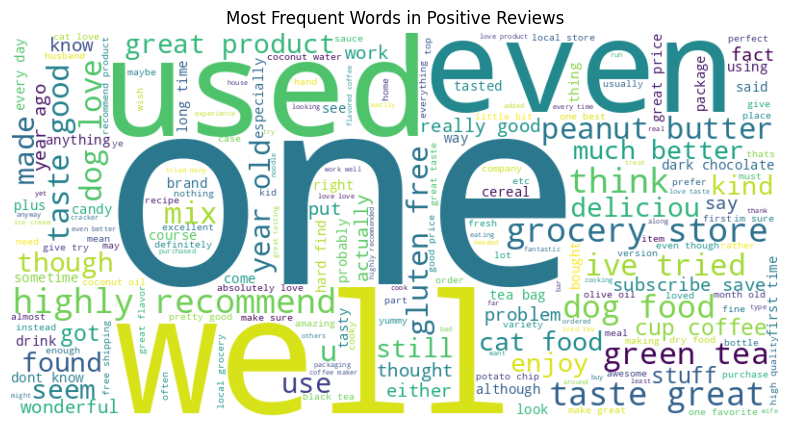

In [27]:
positive_review = " ".join(requiredData[requiredData['Sentiment']==1]['Processed_Text'])
wc_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_review)
plt.figure(figsize=(10, 5))
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()

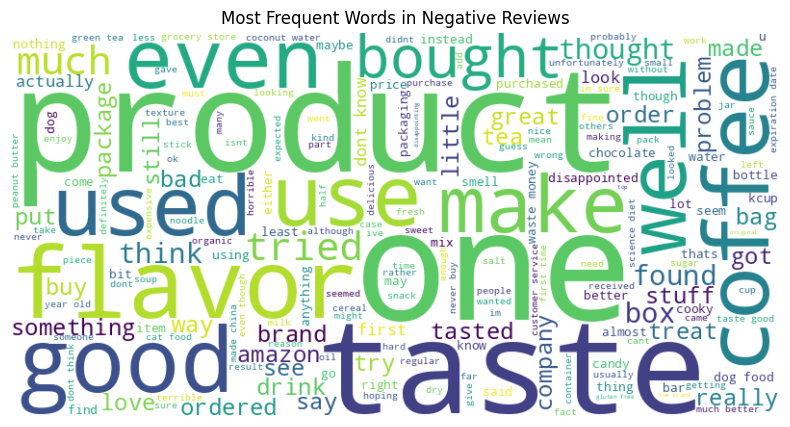

In [28]:
negative_review = " ".join(requiredData[requiredData['Sentiment']==0]['Processed_Text'])
wc_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_review)
plt.figure(figsize=(10, 5))
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')
plt.show()

In [29]:
X=requiredData['Processed_Text']
Y=requiredData['Sentiment']

In [30]:
weighted_importance=TfidfVectorizer(ngram_range=(1, 3))
X_vec=weighted_importance.fit_transform(X)

In [31]:
x_train,x_test,y_train,y_test=train_test_split(X_vec,Y,test_size=0.2,random_state=42)

Multinomial Naive Bayes

In [32]:

naiveB=MultinomialNB()
naiveB.fit(x_train,y_train)

MultinomialNB()

In [ ]:
#MultinomialNB with approx 85% accuracy
y_pred_nb=naiveB.predict(x_test)
accuracy_of_model_nb=accuracy_score(y_test,y_pred_nb)
classify_report_nb=classification_report(y_test,y_pred_nb,output_dict=True)
confuse_matrix_nb=confusion_matrix(y_test,y_pred_nb)

In [36]:
classify_report_nb=pd.DataFrame(classify_report_nb).transpose()
print(accuracy_of_model_nb,"\n",classify_report_nb,"\n",confuse_matrix_nb)

0.8502753994655614 
               precision    recall  f1-score       support
0              1.000000  0.042880  0.082233  11474.000000
1              0.849264  1.000000  0.918489  61874.000000
accuracy       0.850275  0.850275  0.850275      0.850275
macro avg      0.924632  0.521440  0.500361  73348.000000
weighted avg   0.872844  0.850275  0.787671  73348.000000 
 [[  492 10982]
 [    0 61874]]


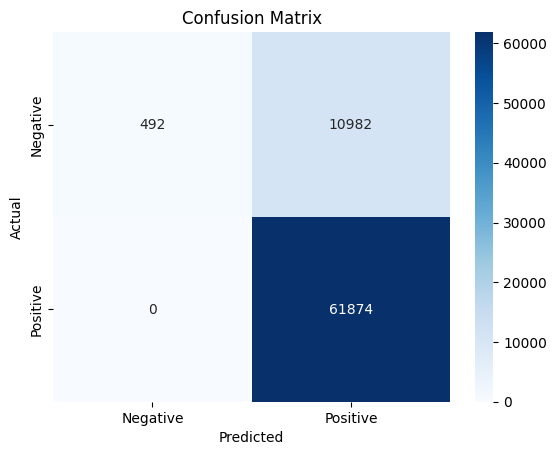

In [37]:
sns.heatmap(confuse_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Logistic Regression

In [33]:
logistic=LogisticRegression()
logistic.fit(x_train,y_train)


LogisticRegression()

In [ ]:
#LogisticRegression with approx 93% accuracy
y_pred_lr=logistic.predict(x_test)
accuracy_of_model_lr=accuracy_score(y_test,y_pred_lr)
classify_report_lr=classification_report(y_test,y_pred_lr,output_dict=True)
confuse_matrix_lr=confusion_matrix(y_test,y_pred_lr)

In [39]:
classify_report_lr=pd.DataFrame(classify_report_lr).transpose()
print(accuracy_of_model_lr,"\n",classify_report_lr,"\n",confuse_matrix_lr)

0.9320908545563614 
               precision    recall  f1-score       support
0              0.942966  0.602318  0.735095  11474.000000
1              0.930884  0.993244  0.961053  61874.000000
accuracy       0.932091  0.932091  0.932091      0.932091
macro avg      0.936925  0.797781  0.848074  73348.000000
weighted avg   0.932774  0.932091  0.925706  73348.000000 
 [[ 6911  4563]
 [  418 61456]]


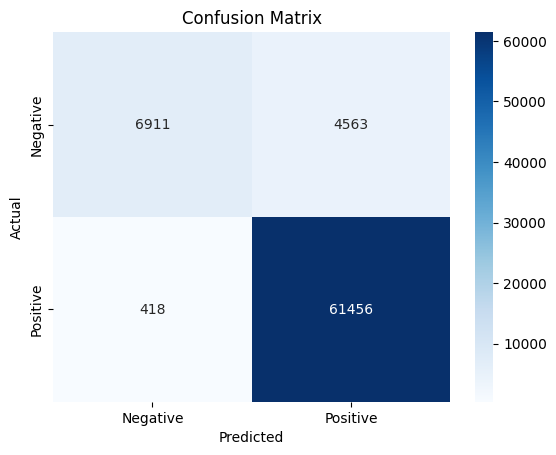

In [40]:
sns.heatmap(confuse_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Support Vector Classifier

In [34]:
svc=LinearSVC()
svc.fit(x_train,y_train)

LinearSVC()

In [ ]:
#Linear Support Vector Classifier with approx 95% accuracy
y_pred_svc=svc.predict(x_test)
accuracy_of_model_svc=accuracy_score(y_test,y_pred_svc)
classify_report_svc=classification_report(y_test,y_pred_svc,output_dict=True)
confuse_matrix_svc=confusion_matrix(y_test,y_pred_svc)

In [42]:
classify_report_svc=pd.DataFrame(classify_report_svc).transpose()
print(accuracy_of_model_svc,"\n",classify_report_svc,"\n",confuse_matrix_svc)

0.9565495991710748 
               precision    recall  f1-score      support
0              0.935013  0.776190  0.848231  11474.00000
1              0.959764  0.989996  0.974645  61874.00000
accuracy       0.956550  0.956550  0.956550      0.95655
macro avg      0.947388  0.883093  0.911438  73348.00000
weighted avg   0.955892  0.956550  0.954870  73348.00000 
 [[ 8906  2568]
 [  619 61255]]


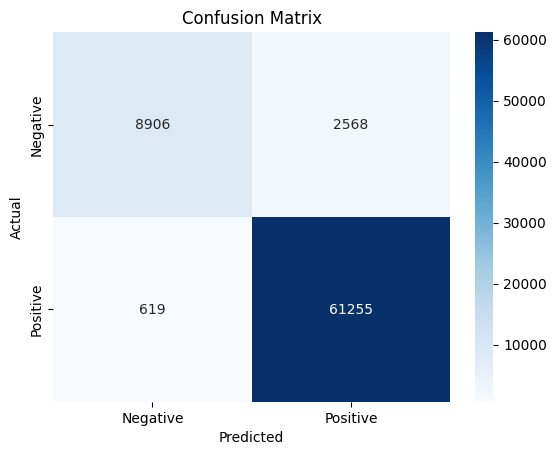

In [43]:
sns.heatmap(confuse_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Prediction Function

In [50]:
def prediction(text):
    processed_text=preprocess_text(text)
    vec=weighted_importance.transform([processed_text])
    answer=svc.predict(vec)
    return "Positive Review" if answer[0]==1 else "Negative Review"

In [52]:
review1 = "I really like the Maple and Brown Sugar flavor. The regular is fine with brown sugar added. The Apples and Cinnamon flavor is OK. This is a very quick, easy and satisfying breakfast and I'll order this brand again, but not the variety. I'll get all Maple and Brown Sugar."
review2 = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

print(f"Review: '{review1}' -> Sentiment: {prediction(review1)}")
print(f"Review: '{review2}' -> Sentiment: {prediction(review2)}")

Review: 'I really like the Maple and Brown Sugar flavor. The regular is fine with brown sugar added. The Apples and Cinnamon flavor is OK. This is a very quick, easy and satisfying breakfast and I'll order this brand again, but not the variety. I'll get all Maple and Brown Sugar.' -> Sentiment: Positive Review
Review: 'This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.' -> Sentiment: Negative Review
